<a href="https://colab.research.google.com/github/Mananalik/Food_Freshness_Classification/blob/main/Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets -q

In [8]:
import opendatasets as od
print("Downloading sensor dataset...")
od.download('https://www.kaggle.com/datasets/mehrabmahdian/food-freshness-electronic-nose-data')

print("\n✅ Sensor dataset downloaded successfully!")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mananjaat28
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mehrabmahdian/food-freshness-electronic-nose-data


100%|██████████| 9.81M/9.81M [00:00<00:00, 1.24GB/s]


✅ Sensor dataset downloaded successfully!


In [ ]:
!pip install tensorflow

In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

In [10]:
DATA_DIRECTORY = 'food-freshness-electronic-nose-data/AllSmaples-Report/'
SENSOR_COLUMNS = ['MQ3', 'MQ8', 'MQ135']
SEQUENCE_LENGTH = 180

In [18]:
def load_and_preprocess_data(data_dir, sensor_list, seq_len):
    all_data = []
    labels = []
    freshness_mapping = {'D1': 0, 'D2': 1, 'D3': 2, 'D4': 3, 'D5': 4}

    print("--- Loading and parsing data files ---")
    for filename in os.listdir(data_dir):
        if filename.endswith(".csv"):
            parts = filename.replace('.csv', '').split(' ')
            if len(parts) > 1 and parts[-1] in freshness_mapping:
                label = freshness_mapping[parts[-1]]
                filepath = os.path.join(data_dir, filename)
                df = pd.read_csv(filepath)


                if all(col in df.columns for col in sensor_list):
                    df_sensors = df[sensor_list]

                    step_size = 30
                    for i in range(0, len(df_sensors) - seq_len + 1, step_size):
                        sequence = df_sensors.iloc[i:i + seq_len].values
                        all_data.append(sequence)
                        labels.append(label)
                else:
                    print(f"Skipping {filename}: does not contain all required sensors.")
            else:
                print(f"Skipping {filename}: unrecognized freshness label.")

    X_sequences = np.array(all_data)
    y_labels = np.array(labels)
    freshness_labels = {v: k for k, v in freshness_mapping.items()}

    print(f"\nTotal sequences created: {len(X_sequences)}")
    return X_sequences, y_labels, freshness_labels

In [19]:
def scale_data(X_train, X_test):
    print("\n--- Scaling data ---")
    n_features = X_train.shape[2]
    X_train_reshaped = X_train.reshape(-1, n_features)
    scaler = StandardScaler()
    X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
    X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)

    X_test_reshaped = X_test.reshape(-1, n_features)
    X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
    X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)

    return X_train_scaled, X_test_scaled, scaler

In [20]:
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=input_shape, name="Conv1D_1"),
        MaxPooling1D(pool_size=2, name="MaxPool_1"),
        Dropout(0.4, name="Dropout_1"),

        LSTM(200, return_sequences=True, name="LSTM_1"),
        Dropout(0.4, name="Dropout_2"),

        LSTM(100, name="LSTM_2"),
        Dropout(0.4, name="Dropout_3"),

        Dense(100, activation='relu', name="Dense_1"),
        Dense(num_classes, activation='softmax', name="Output_Layer")
    ], name="Tuned_CNN_LSTM_Hybrid")

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
try:

    X, y_raw, freshness_labels = load_and_preprocess_data(DATA_DIRECTORY, SENSOR_COLUMNS, SEQUENCE_LENGTH)


    num_classes = len(np.unique(y_raw))
    y_one_hot = tf.keras.utils.to_categorical(y_raw, num_classes=num_classes)
    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y_raw)

    X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test)
    joblib.dump(scaler, 'time_series_scaler.pkl')
    print("✅ Scaler saved to 'time_series_scaler.pkl'")


    input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.summary()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
    ]

    print("\n--- Training CNN-LSTM Model ---")
    history = model.fit(
        X_train_scaled, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test_scaled, y_test),
        callbacks=callbacks,
        verbose=1
    )


    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"\n🎯 Final Model Accuracy: {accuracy*100:.2f}%")

    with open('freshness_labels.json', 'w') as f:
        json.dump(freshness_labels, f)
    print("✅ Label mapping saved to 'freshness_labels.json'")
    print("\n--- Project Complete! ---")

except Exception as e:
    print(f"\nAn error occurred: {e}")

--- Loading and parsing data files ---
Skipping Mandarin.csv: unrecognized freshness label.
Skipping AppleBananaTomato.csv: unrecognized freshness label.
Skipping AppleTomato.csv: unrecognized freshness label.
Skipping AppleBanana.csv: unrecognized freshness label.
Skipping AppleBananaMandarin.csv: unrecognized freshness label.
Skipping TomatoBanana.csv: unrecognized freshness label.
Skipping BananaMandarin.csv: unrecognized freshness label.
Skipping TomatoMandarin.csv: unrecognized freshness label.
Skipping AppleMandarin.csv: unrecognized freshness label.

Total sequences created: 21613

--- Scaling data ---
✅ Scaler saved to 'time_series_scaler.pkl'


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Tuned_CNN_LSTM_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)               │ (None, 176, 256)       │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_1 (MaxPooling1D)        │ (None, 88, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 88, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 88, 200)        │       365,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 88, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,701 (1.91 MB)

 Trainable params: 500,701 (1.91 MB)

 Non-trainable params: 0 (0.00 B)


--- Training CNN-LSTM Model ---
Epoch 1/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4518 - loss: 1.1923 - val_accuracy: 0.6660 - val_loss: 0.7420
Epoch 2/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6971 - loss: 0.7155 - val_accuracy: 0.8277 - val_loss: 0.4620
Epoch 3/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7961 - loss: 0.5315 - val_accuracy: 0.8508 - val_loss: 0.4023
Epoch 4/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8389 - loss: 0.4405 - val_accuracy: 0.8552 - val_loss: 0.3674
Epoch 5/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8557 - loss: 0.4015 - val_accuracy: 0.8998 - val_loss: 0.2663
Epoch 6/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8598 - loss: 0.3766 - val_accuracy: 0.8945 - val_loss: 0.2653
Epoch 7/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8799 - loss: 0.3286 - val_accuracy: 0.8917 - val_loss: 0.3026
Epoch 8/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy

In [22]:
from google.colab import files
import pandas as pd

# --- Settings ---
START_ROW = 4500
END_ROW = 5580
# V V V THIS IS THE LINE I CHANGED V V V
INPUT_FILE = "test dataset - Sheet1.csv" # Use the exact name of the file you uploaded
OUTPUT_FILE = "challenge.csv"
# ---

# We don't need to upload again if the file is already there
try:
    print(f"Loading {INPUT_FILE}...")
    full_live_data = pd.read_csv(INPUT_FILE)

    if len(full_live_data) >= END_ROW:
        challenge_data = full_live_data.iloc[START_ROW:END_ROW]
        challenge_data.to_csv(OUTPUT_FILE, index=False)
        print(f"✅ Successfully created {OUTPUT_FILE} with {len(challenge_data)} rows.")
    else:
        print(f"❌ Error: The file {INPUT_FILE} is too short.")

except FileNotFoundError:
    print(f"❌ Error: Could not find the file {INPUT_FILE}.")
    print("Please try uploading the file again in the cell above.")
except Exception as e:
    print(f"An error occurred: {e}")

Loading test dataset - Sheet1.csv...
✅ Successfully created challenge.csv with 1080 rows.


In [23]:
import pandas as pd
import numpy as np
import joblib
import json
import tensorflow as tf
import sys

# --- Constants for the test function ---
SCALER_PATH = 'time_series_scaler.pkl'
LABELS_PATH = 'freshness_labels.json'
MODEL_TO_TEST = 'best_model.keras' # This is the model your training cell saved
CHALLENGE_CSV = 'test dataset - Sheet1.csv' # The file you created in the cell above
WINDOW_SIZE = 180
STEP_SIZE = 60 # Using a smaller, overlapping step for a detailed view

def evaluate_model_confidence(model_path, challenge_csv_path):
    """
    Loads a trained model and evaluates it on the challenge CSV.
    """
    print(f"\n🚀 Starting confidence test for: {model_path}")

    # --- 1. Load Helpers ---
    try:
        scaler = joblib.load(SCALER_PATH)
        with open(LABELS_PATH, 'r') as f:
            freshness_labels = json.load(f)
    except Exception as e:
        print(f"❌ Error loading helpers (scaler/labels): {e}")
        print("➡️ Make sure you have run your main training cell first!")
        return

    # --- 2. Load the Model ---
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"✅ Successfully loaded model and helpers.")
    except Exception as e:
        print(f"❌ Error loading model '{model_path}': {e}")
        print("➡️ Make sure your main training cell has run and saved the model.")
        return

    # --- 3. Load and Process Challenge Data ---
    try:
        live_df = pd.read_csv(challenge_csv_path)
        print(f"📄 Loaded '{challenge_csv_path}' with {len(live_df)} readings.")

        if len(live_df) < WINDOW_SIZE:
            print(f"❌ Error: Data is too short (need {WINDOW_SIZE} readings).")
            return

        print(f"--- Analysis (Window: {WINDOW_SIZE}, Step: {STEP_SIZE}) ---")

        # --- 4. Run Sliding Window ---
        for i in range(0, len(live_df) - WINDOW_SIZE + 1, STEP_SIZE):

            data_chunk = live_df[['MQ3', 'MQ8', 'MQ135']].iloc[i : i + WINDOW_SIZE]
            live_data = data_chunk.values

            scaled_data = scaler.transform(live_data)
            scaled_data_batch = np.expand_dims(scaled_data, axis=0)

            probs = model.predict(scaled_data_batch, verbose=0)[0]

            # --- 5. Get Top Prediction ---
            prediction_index = np.argmax(probs)
            prediction_label = freshness_labels[str(prediction_index)]
            confidence = probs[prediction_index]

            # --- 6. Get Runner-Up Prediction ---
            temp_probs = np.copy(probs)
            temp_probs[prediction_index] = 0 # Zero out the top prediction
            runner_up_index = np.argmax(temp_probs)
            runner_up_label = freshness_labels[str(runner_up_index)]
            runner_up_confidence = temp_probs[runner_up_index]

            # --- 7. Print Results ---
            print(f"Chunk (Readings {i} to {i + WINDOW_SIZE - 1}):")
            print(f" ➡️ {prediction_label} (Confidence: {confidence*100:.2f}%)")
            print(f"    Runner-up: {runner_up_label} (Confidence: {runner_up_confidence*100:.2f}%)")

    except Exception as e:
        print(f"❌ An error occurred during analysis: {e}")

# --- RUN THE TEST ---
evaluate_model_confidence(model_path=MODEL_TO_TEST,
                          challenge_csv_path=CHALLENGE_CSV)


🚀 Starting confidence test for: best_model.keras
✅ Successfully loaded model and helpers.
📄 Loaded 'test dataset - Sheet1.csv' with 12879 readings.
--- Analysis (Window: 180, Step: 60) ---
Chunk (Readings 0 to 179):
 ➡️ D5 (Confidence: 95.74%)
    Runner-up: D4 (Confidence: 4.14%)
Chunk (Readings 60 to 239):
 ➡️ D5 (Confidence: 95.70%)
    Runner-up: D4 (Confidence: 4.17%)
Chunk (Readings 120 to 299):
 ➡️ D5 (Confidence: 95.68%)
    Runner-up: D4 (Confidence: 4.19%)
Chunk (Readings 180 to 359):
 ➡️ D5 (Confidence: 95.67%)
    Runner-up: D4 (Confidence: 4.19%)
Chunk (Readings 240 to 419):
 ➡️ D5 (Confidence: 95.57%)
    Runner-up: D4 (Confidence: 4.27%)
Chunk (Readings 300 to 479):
 ➡️ D5 (Confidence: 95.59%)
    Runner-up: D4 (Confidence: 4.26%)
Chunk (Readings 360 to 539):
 ➡️ D5 (Confidence: 95.49%)
    Runner-up: D4 (Confidence: 4.34%)
Chunk (Readings 420 to 599):
 ➡️ D5 (Confidence: 95.45%)
    Runner-up: D4 (Confidence: 4.36%)
Chunk (Readings 480 to 659):
 ➡️ D5 (Confidence: 95.4

🚀 Loading model to generate report...
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- Classification Report ---
              precision    recall  f1-score   support

          D1       1.00      1.00      1.00      1005
          D2       0.99      0.96      0.98       877
          D3       0.96      1.00      0.98       849
          D4       0.99      0.97      0.98       824
          D5       0.98      0.98      0.98       768

    accuracy                           0.98      4323
   macro avg       0.98      0.98      0.98      4323
weighted avg       0.98      0.98      0.98      4323


--- Confusion Matrix ---


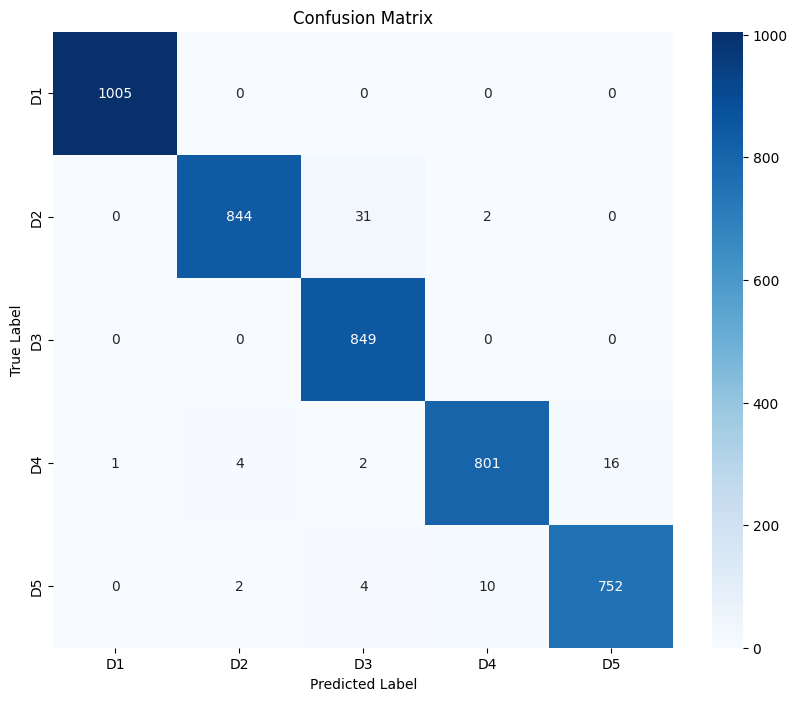

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# --- SETTINGS ---
MODEL_PATH = 'best_model.keras'
CLASS_NAMES = ['D1', 'D2', 'D3', 'D4', 'D5'] # Make sure this order is correct!
# ---

print("🚀 Loading model to generate report...")
# Load the model, scaler, and labels
model = tf.keras.models.load_model(MODEL_PATH)
with open('freshness_labels.json', 'r') as f:
    freshness_labels = json.load(f)

# We need the y_test variable from your training cell.
# If you get a "y_test not defined" error, re-run your main training cell.
try:
    # Get the model's predictions on the TEST set
    y_pred_probs = model.predict(X_test_scaled)

    # Convert probabilities to single class labels (e.g., [0.1, 0.9] -> 1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Also convert the one-hot y_test back to single class labels
    y_true = np.argmax(y_test, axis=1)

    # --- 1. The Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    # --- 2. The Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

except NameError:
    print("\n❌ ERROR: 'X_test_scaled' or 'y_test' not found.")
    print("Please re-run your main training cell to put them in memory, then run this cell again.")
except Exception as e:
    print(f"\nAn error occurred: {e}")